In [132]:
# Import Data

import pandas as pd
# The raw content URL for the CSV file on GitHub
url = "https://raw.githubusercontent.com/MikeysPetSnakeCollection/cmse492_aml/main/ca_housing_project/Data/Raw/housing.csv"
# Load the data directly from the URL into a pandas DataFrame
housing = pd.read_csv(url)



# The raw content URL for the CSV file on GitHub
url = "https://raw.githubusercontent.com/MikeysPetSnakeCollection/cmse492_aml/main/ca_housing_project/Data/Train/housing_train.csv"
# Load the data directly from the URL into a pandas DataFrame
housing_train = pd.read_csv(url)

housing_train.info()







<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
 10  rooms_per_house     16512 non-null  float64
 11  bedrooms_ratio      16344 non-null  float64
 12  people_per_house    16512 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.6+ MB


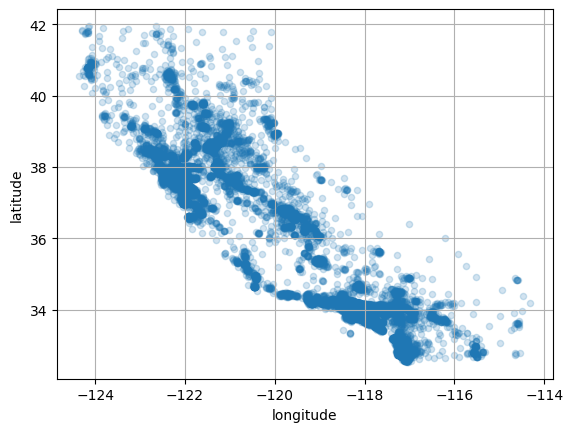

In [134]:
#Geographic Data Visualization
#All of this is also done in IDA
import matplotlib.pyplot as plt
#Geographical data plots
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()



median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


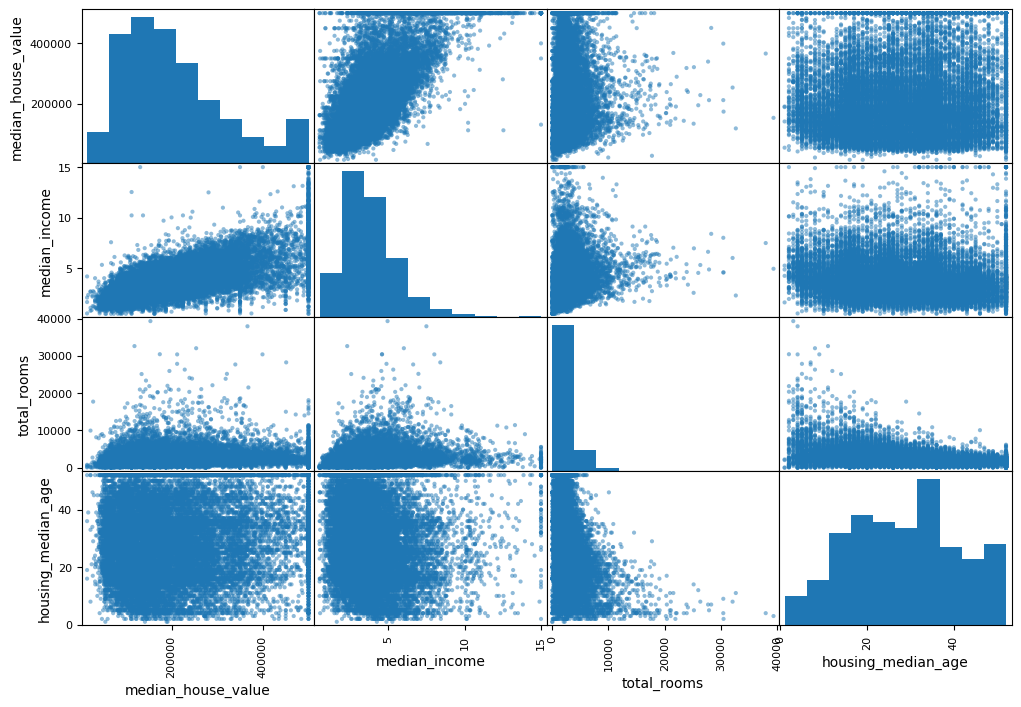

In [136]:
#Feature Correlation Analysis
#All of this is also done in IDA

#Correlation Matrix
housing_num = housing.select_dtypes(include='number')
corr_matrix = housing_num.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))


from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()



In [137]:
#Feature Engineering and Creation
# cluster similarities, incorporate clusters into data



import tarfile
import urllib.request
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
 "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]
cat_pipeline = make_pipeline(
SimpleImputer(strategy="most_frequent"),
OneHotEncoder(handle_unknown="ignore"))


class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]





def column_ratio(X):
    return X[:, [0]] / X[:, [1]]
def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out
def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age




"""
housing_labels = housing_train["median_house_value"].copy()
housing_train = housing_train.drop("median_house_value",axis=1)
housing_train = housing_train.drop("rooms_per_house",axis=1)
housing_train = housing_train.drop("bedrooms_ratio",axis=1)
housing_train = housing_train.drop("people_per_house",axis=1)
"""



#housing_train.info()



housing_prepared = preprocessing.fit_transform(housing_train)
print(housing_prepared.shape)
preprocessing.get_feature_names_out()
"""
housing_train_preprocessed = pd.DataFrame(housing_prepared)
housing_train_preprocessed.to_csv(Path("ca_housing_project/Data/Train/housing_train_preprocessed.csv"),index=False)

"""



(16512, 28)


'\nhousing_train_preprocessed = pd.DataFrame(housing_prepared)\nhousing_train_preprocessed.to_csv(Path("ca_housing_project/Data/Train/housing_train_preprocessed.csv"),index=False)\n\n'